In [66]:
# import necessary modules
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# loading dataset
train_df = pd.read_csv("data/sign_mnist_train.csv")
test_df = pd.read_csv("data/sign_mnist_test.csv")

# splitting data (70% training, 15% validation, 15% testing)
X = train_df.drop("label", axis=1).values
y = train_df["label"].values
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# normalizing pixel values (0-255) to (0-1)
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# converting to tensors
X_train_tensor = torch.FloatTensor(X_train).view(-1, 1, 28, 28).to(device)
X_val_tensor = torch.FloatTensor(X_val).view(-1, 1, 28, 28).to(device)
X_test_tensor = torch.FloatTensor(X_test).view(-1, 1, 28, 28).to(device)
y_train_tensor = torch.LongTensor(y_train).to(device)
y_val_tensor = torch.LongTensor(y_val).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

In [ ]:
# CNN models

# first iteration
class ASL_CNN(nn.Module):
    def __init__(self, num_classes):
        super(ASL_CNN, self).__init__()
        # convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        # pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # fully connected layers
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, num_classes)
        # dropout
        self.dropout = nn.Dropout(0.5)
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class OptimizedASL_CNN(nn.Module):
    def __init__(self, num_classes):
        super(OptimizedASL_CNN, self).__init__()
        # convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)  # less filters
        self.bn1 = nn.BatchNorm2d(16)  # using batch normalization
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        # pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # fully connected layers
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)
        
        # Dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1) # flattenning
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # output layer
        return x


class SimpleNN(nn.Module):
    def __init__(self, num_classes, input_size=784):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x) 
        return x

In [68]:
#--------------Functions---------------------------
# defining training model
def train_model(model, criterion, optimizer, num_epochs=20):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        # evaluate on validation set
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)
            val_losses.append(val_loss.item())
        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')
    return train_losses, val_losses

# evaluating CNN
def evaluate_model(model):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, predictions = torch.max(outputs, 1)
        accuracy = (predictions == y_test_tensor).float().mean().item()
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    return predictions

# plotting losses
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# visualizing predictions
def plot_predictions(model, num_images=5):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor[:num_images])
        _, predictions = torch.max(outputs, 1)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        img = X_test_tensor[i].cpu().squeeze().numpy()
        axes[i].imshow(img, cmap="gray")
        axes[i].set_title(f"Predicted: {predictions[i].item()}")
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

Epoch [20/100], Train Loss: 1.3350, Val Loss: 2.7657
Epoch [40/100], Train Loss: 0.5435, Val Loss: 0.8340
Epoch [60/100], Train Loss: 0.2563, Val Loss: 0.1645
Epoch [80/100], Train Loss: 0.1433, Val Loss: 0.0505
Epoch [100/100], Train Loss: 0.0905, Val Loss: 0.0217
Test Accuracy: 100.00%


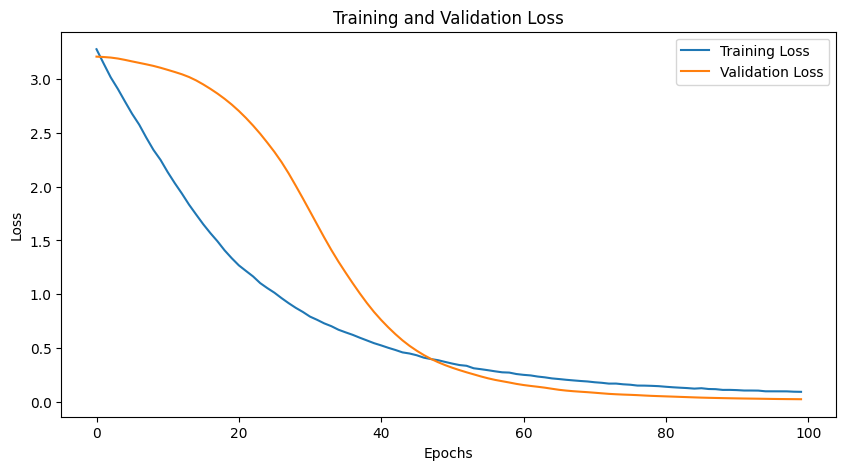

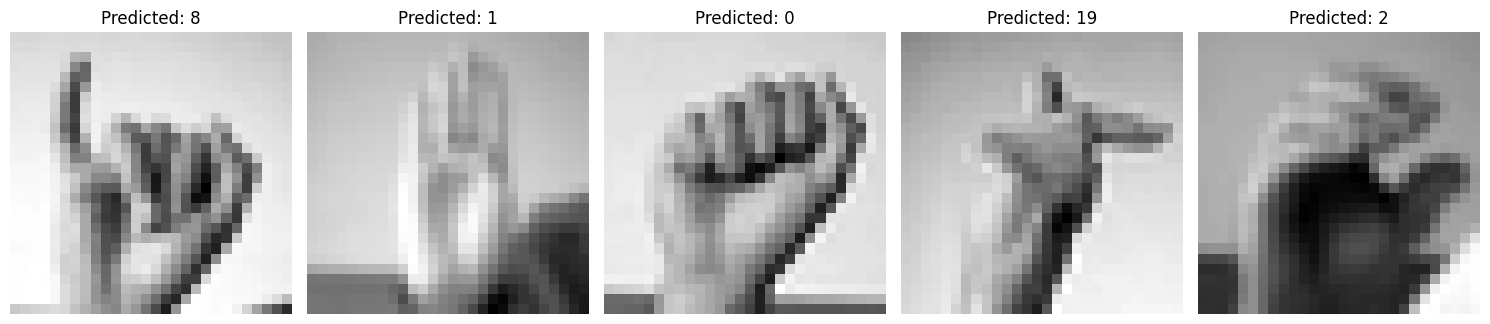

In [ ]:
# initializing
num_classes = max(y) + 1
model = OptimizedASL_CNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# training CNN
train_losses, val_losses = train_model(model, criterion, optimizer, num_epochs=100)
# evaluating and printing results
predictions = evaluate_model(model)
plot_losses(train_losses, val_losses)
plot_predictions(model, num_images=5)